# Do player with a higher rating have a higher probability of castling in chess?

## Introduction

When I read about chess to improve my skills, I often came across the importance of castling to increase king safety and to develop a rook at the same time. The more I played, the more I realised that it's increadibly useful to move two pieces during one turn. I thought, well certainly it should always be done in a match!

But when I started watching high level players, I came across multiple games that players did not castle, which was suprising to me. In addition, in one video about chess engines, the youtuber gothamchess said that thoses engines often don't castle. Which was weird to me, because they are by far better than humans in ratings that can go higher than 3600 compared to the highest rated human of all time, Magnus Carlsen, who is a tad below 2900.


So I formulated the hypothesis that beginner players have a low probability of castling and the probability of this action accuring is increasing until the level of GM (2500 elo) and decreasing afterwards.

# Data gathering

To gather data, I used the open source site : lichess.org which at the end of each month, releases a file, in the pgn format, of all the games played. This file is easily readable with a parser https://database.lichess.org. After getting the data, I kept the information about every move both players made during a match, separated by colors (white and black), so I could later identify if there was a castle. I did this by using a regular expression that can be found here: https://regex101.com/r/66I1uc/1. I extracted all the relevant data that would be useful to describe the probability of castling. The variables that I chose to keep were: the rating of the player and the rating difference between the two players. Here is an extract of the data collected this way :

In [1]:
import pandas as pd
import chess.pgn
import chess_fun
import matplotlib.pyplot as plt
import numpy as np
import fonctionsUtiles as utile
import seaborn as sns

# Saving the data in a pickle so we can fetch it if we need it later
try: 
    df = pd.read_pickle("Lichess_JupyterLab.pkl")
except FileNotFoundError:
    df = chess_fun.df_from_png("D:/lichessGames/lichess_db_standard_rated_2021-12.pgn", "Lichess_JupyterLab.pkl", 100000);

In [2]:
## Looking at the data :

df.head()

,White elo,Black elo,White castle,Black castle,white short,White long,black short,black long,White rating diff,Black rating diff,Event type
0,1301,1366,0,1,0,0,1,0,-65,65,Rated Bullet game
1,1960,1928,1,1,1,0,1,0,32,-32,Rated Bullet game
2,1984,1989,1,1,1,0,1,0,-5,5,Rated Bullet game
3,1054,1156,0,1,0,0,1,0,-102,102,Rated Bullet game
4,887,845,1,1,0,1,1,0,42,-42,Rated Bullet game


To create the castle dataframe, I separated white moves and the black moves so the df_castle dataframe has twice the amount of rows than the original dataframe. I only kept the data that was relevant for the according players. I collapsed the information about the short and long castles, because for this project, I wanted to focus only on the propability of castle.

I saved the information about the type of events (blitz, rapid, classical, etc.) the participants are playing since depending of the time control, it could be possible that the behaviour of players change. For example, a blitz game is generally below 10 minutes whereas a classical game can be up to 7 hours. Therefore, players usually play more agressively in blitz, which could impact the probability of castling.

In [3]:
df_castle = chess_fun.create_castle_df(df)
df_castle.head()

,Player elo,Castle,Rating diff,Event type
0,1301,0,-65,Rated Bullet game
1,1366,1,65,Rated Bullet game
2,1960,1,32,Rated Bullet game
3,1928,1,-32,Rated Bullet game
4,1984,1,-5,Rated Bullet game


# First observations

Looking at the data from the following figure, it seems clear that there is a positive relationship between the probability that a player castle and their rating. The players that have a rating between 600 and 800 elo points castle less than 40% of the time, whereas players with a rating higher than 2000 castle about 85% of the time. This important difference surprised me. But the thing that I found the most interesting was that there seemed to be a plateau at rating of 2000. 


# Who might find this information useful

These results could be useful for players with a rating below 2000 and that castle less that 80% of the time. It's probable that these players underestimate the importance of castling and that is a hurdle to their chess progression. Unfortunately, it doesn't mean that castling more would increase their ratings. However, every time they choose not to castle, they should evaluate the play carefully to determine two things 1) is not castling the best play for them and 2) understand what they are giving up by not doing so.

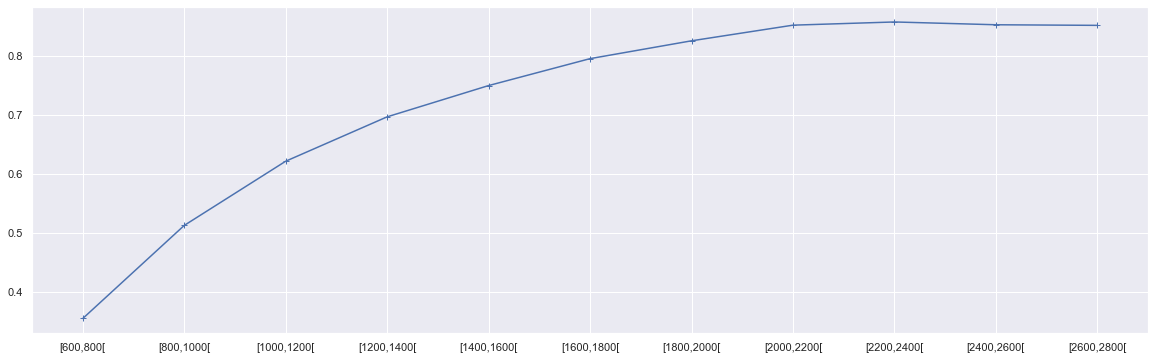

In [4]:
data, matrice = utile.cut_dataframe(df_castle,"Player elo", 200)
plt.rcParams['figure.figsize'] = [20, 6]
plt.plot(matrice,data["Castle"],'-+')
plt.show()

## Log reg model

Using the logistic regression model, we can verify if the relationship between the rating and the castling probability is statistifically significiant. Therefore, if we would analyse another set of data, we would likelly see the same relationship between the ratings and the probability of castling.

In [5]:
import statsmodels.api as sm

y = df_castle['Castle']
X = sm.add_constant(df_castle[['Player elo', "Rating diff"]])

logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary2())

C:\Users\maxime\anaconda3\envs\machineLearning\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


Optimization terminated successfully.
         Current function value: 0.524431
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.036      
Dependent Variable: Castle           AIC:              209778.3442
Date:               2022-03-16 13:16 BIC:              209808.9624
No. Observations:   200000           Log-Likelihood:   -1.0489e+05
Df Model:           2                LL-Null:          -1.0883e+05
Df Residuals:       199997           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
const         -0.9136    0.0244  -37.4727  0.0000  -0.9614  -0.8658
Player elo     0.0013    0.0000   85.9874  0.0000

So there is a stong relationship between the player elo and the probability of castling with a z score of over 85. Yet, even when adding the rating difference, we can only explain 4% of the probability of castling. Therefore, they are likely many unobservable factors that determine if a player will castle or not. Some factors like their opening repertoire and how their opponent are playing. Because the goal of this analysis was to proove that their is a strong relationship between player skill and castling probability, not to explain why a player castles, I am satisfied with these results and won't add more features to increase the r<sup>2</sup>.

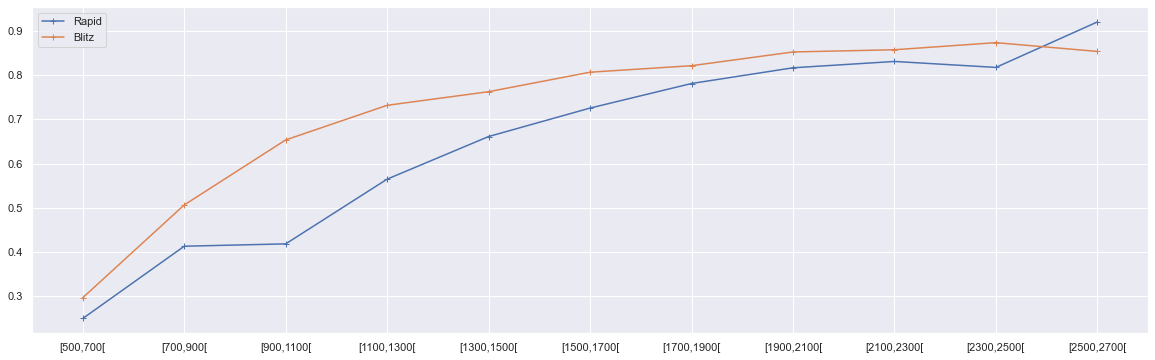

In [6]:
df_Blitz = df[df["Event type"] == "Rated Bullet game"]
df_Rapid = df[df["Event type"] == "Rated Rapid game"]

df_castle_Blitz = chess_fun.create_castle_df(df_Blitz)
df_castle_Rapid = chess_fun.create_castle_df(df_Rapid)

matrice = np.arange(300, 2900, 200) #(min, max, step)

dataRapid, matriceRapid = utile.cut_dataframe(df_castle_Rapid,"Player elo", matrice = matrice)
dataBlitz, matriceBlitz = utile.cut_dataframe(df_castle_Blitz,"Player elo", matrice = matrice)

plt.plot(matriceRapid,dataRapid["Castle"],'-+', label = "Rapid")
plt.plot(matriceBlitz,dataBlitz["Castle"],'-+', label = "Blitz")

plt.legend()
plt.show()


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5, random_state = 0)
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
print("The prediction formulated by the logreg model is correct about {:.2f}% of the time".format(logreg.score(X_test,y_test) *100))

The prediction formulated by the logreg model is correct about 76.59% of the time


So despite the really low r<sup>2</sup>, the algorithm's prediction on the test set is relatively high because it separates players between two groups: group A that always castles and group B that never castles based on their rating. Since, low level players almost never castle and high level players almost always castle, the algorithm is right most of the time.


## Conclusion

My first hypothesis was wrong because the probability of castling is increasing continiously on the data that I have collected. However, there is a plateau of the probablity of castling at about 2000 elo points where players castle on average 85% of the time. For further analysis it would be interesting to add data of computer games where the level of play is better than humans to see if the findings are similar. For example, if the computers castle less that 85% of the time it might be that there is a better strategy than castling 85% of the time even though it's the strategy used by the top players currently.